In [34]:
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
from IPython.core.display import HTML, display
display(HTML("<style> .container{width:100% !important} </style>"))

In [24]:
df1=pd.read_csv('Full-Economic-News-DFE-839861.csv'
                , encoding='ISO-8859-1')
df2=pd.read_csv('us-economic-newspaper.csv', encoding='ISO-8859-1')
df = pd.concat([df1, df2], sort=False)
df = df.sample(frac=1).reset_index(drop=True)

In [25]:
df.head(2)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text,orig__golden,lineid,next_sentence,previous_sentence
0,729488866,False,finalized,3,6/8/15 9:30,4.0,0.61,yes,1.0000,120403428,6/4/75,Market Place: How Banks' Trust Departments Did,NaN,NaN,Now the market has shown remarkable strength i...,NaN,120403428_02,"However, as the Wall Street saying goes, never...",Major banksÛª trust departments have had thei...
1,729491267,False,finalized,3,6/10/15 19:28,NaN,0.00,no,0.7027,120112925,8/11/74,Reading the Stock Market's Signals on Watergate,NaN,NaN,WASHINGTON ÛÓ This anguished political town h...,NaN,120112925_01,"On Friday, with the details of Presidential ch...",NaN


In [26]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'positivity', 'positivity:confidence', 'relevance',
       'relevance:confidence', 'articleid', 'date', 'headline',
       'positivity_gold', 'relevance_gold', 'text', 'orig__golden', 'lineid',
       'next_sentence', 'previous_sentence'],
      dtype='object')

In [27]:
# Data Preprocessing steps 
# step 1; select columns "text", "positivity"
# step 2; remove rows with NaN positivity
# step 3; remove punctuation
# step 4; remove stop words
# step 5; stemming words, to get effictive part of word in training
# step 6; count vectorizer, convert articles to vecotrs of 0's - 1's

In [28]:
def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words 
                        if not w in stops]
    return(" ".join( meaningful_words ))

Df = df[["positivity", "text"]].dropna()
Df["sentiment"] = 0
Df["words"] = ""
Df.sentiment = Df.positivity.apply(
                        lambda x: 0 if x<5 else 1)
Df.words = Df.text.apply(
                        lambda x: tweet_to_words(x))

del(Df['text'])
del(Df['positivity'])

In [29]:
train, test = train_test_split(Df,test_size=0.2
                               ,random_state=42)
train, val = train_test_split(train,test_size=0.25
                              ,random_state=42)

X_train, y_train = train.words, train.sentiment
X_test, y_test = test.words, test.sentiment
X_val, y_val = val.words, val.sentiment

In [35]:
def stemmming(x):
    porter = PorterStemmer()
    splitted = x.split(' ')
    x = ' '.join([porter.stem(w) for w in splitted])
    return x

X_train = X_train.apply(lambda x:stemmming(x))
X_test = X_test.apply(lambda x:stemmming(x))
X_val = X_val.apply(lambda x:stemmming(x))

v = CountVectorizer(analyzer = "word")
X_train_features = v.fit_transform(X_train)
X_test_features = v.transform(X_test)
X_val_features = v.transform(X_val)

In [36]:
v = CountVectorizer(analyzer = "word")

# Try combining all 3 sets into single set for validation curve

X = pd.concat([X_train, X_test, X_val])
# X = X.sample(frac=1).reset_index(drop=True)

# X_train_features = v.fit_transform(X_train)
# X_test_features = v.transform(X_test)
# X_val_features = v.transform(X_val)
X_features = v.fit_transform(X)

y = pd.concat([y_train, y_test, y_val])
# y = y.sample(frac=1).reset_index(drop=True)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import validation_curve

Accuracy=[]
Model=[]

plt.rcParams.update({'figure.max_open_warning': 0})

In [38]:
def LogisticRegressionModel():
    best_acc = 0
    c_range = [.1, .3, 10, 30]#, 100]
    # for c in ([.01,.03,.1,.3,10]):#,3,10,30,100
    for itr in ([3,10,30,100,300,1000]):#
        classifier = LogisticRegression(solver='liblinear',max_iter=itr)
        prop = ' - itr ' + str(itr)
        title = classifier.__class__.__name__ + prop
        train_scores, test_scores = validation_curve(
            classifier, X_features, y, 'C', c_range, cv=10)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(8,5))
        plt.xlabel("C values")
        plt.ylabel("Score")
        plt.title('Accuracy = {0:.05f}'.format(100*test_scores_mean.max()) + ' ' + prop)
        plt.grid()
        lw = 2
        plt.plot(c_range, train_scores_mean, 'o-', color="r",
                 label="Training score", lw=lw)
        plt.plot(c_range, test_scores_mean, 'o-', color="g",
                 label="Test score", lw=lw)
        plt.fill_between(c_range, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r", lw=lw)
        plt.fill_between(c_range, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g", lw=lw)
        plt.legend(loc="best")
        plt.savefig('project models/{}/'.format(classifier.__class__.__name__) +
            str('{0:.05f} '.format(100*test_scores_mean.max())) + ' ' + prop + ".jpg", dpi=50)
        best_acc = max(best_acc, test_scores_mean.max())
    Accuracy.append(best_acc)
    

In [39]:
def KNeighborsClassifierModel():
    classifier = KNeighborsClassifier(n_neighbors=5, leaf_size=3)
    n_range = range(3,7)
    prop = ''
    title = classifier.__class__.__name__ + prop
    train_scores, test_scores = validation_curve(
        KNeighborsClassifier(), X_train_features, y_train,
                                            'n_neighbors', n_range, cv=10)
#     f = classifier.fit(train_features, train['sentiment'])
#     pred = f.predict(test_features)
#     print(accuracy_score(pred, test['sentiment']))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8,5))
    plt.xlabel("N neigbours")
    plt.ylabel("Score")
    plt.title('Accuracy = {0:.05f}'.format(100*test_scores_mean.max()) + prop)
    plt.grid()
    lw = 2
    plt.plot(n_range, train_scores_mean, 'o-', color="r",
             label="Training score", lw=lw)
    plt.plot(n_range, test_scores_mean, 'o-', color="g",
             label="Test score", lw=lw)
    plt.fill_between(n_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r", lw=lw)
    plt.fill_between(n_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g", lw=lw)
    plt.legend(loc="best")
    plt.savefig('project models/{}/'.format(classifier.__class__.__name__  + prop) +
        str('{0:.05f} '.format(100*test_scores_mean.max())) + ".jpg", dpi=50)
    Accuracy.append(test_scores_mean.max())

In [40]:
def SVCModel():
#     classifier = SVC(kernel='rbf',  probability = True, max_iter = 100)
    c_range = [.001, .003, .01, .03, .1, .3, 1, 3, 10]
    best_acc = 0
    for krnl in ['linear', 'rbf', 'poly', 'sigmoid']:
        f = 0
        for d in range(2,5):
            classifier = SVC(kernel='rbf', gamma='scale', degree = d, probability = True,
                                                                         max_iter = 200)
            if krnl != 'poly':
                prop = ' - krnl ' + krnl
                if f == 1:
                    continue
                else:
                    pass
            else:
                prop = ' - krnl poly with d ' + str(d)
            title = classifier.__class__.__name__ + prop
            train_scores, test_scores = validation_curve(
                classifier, X_train_features, y_train, 'C', c_range, cv=3)
        #     f = KNeighborsClassifier(n_neighbors=5, leaf_size=3)
        #     f.fit(train_features, train['sentiment'])
        #     pred = f.predict(test_features)
        #     print(accuracy_score(pred, test['sentiment']))

            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            plt.figure(figsize=(8,5))
            plt.xlabel("C")
            plt.ylabel("Score")
            plt.title('Accuracy = {0:.05f}'.format(100*test_scores_mean.max()) + prop)
            plt.grid()
            lw = 2
            plt.plot(c_range, train_scores_mean, 'o-', color="r",
                     label="Training score", lw=lw)
            plt.plot(c_range, test_scores_mean, 'o-', color="g",
                     label="Test score", lw=lw)
            plt.fill_between(c_range, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r", lw=lw)
            plt.fill_between(c_range, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g", lw=lw)
            plt.legend(loc="best")
            plt.savefig('project models/{}/'.format(classifier.__class__.__name__) +
                str('{0:.05f} '.format(100*test_scores_mean.max())) + prop + ".jpg", dpi=50)
            best_acc = max(best_acc, test_scores_mean.max())
            f = 1
    Accuracy.append(best_acc)

In [41]:
def DecisionTreeClassifierModel():
    s_range = [2,3,4,5,6]
    best_acc = 0
    for crit in ['gini', 'entropy']:
        classifier = DecisionTreeClassifier(criterion = crit)
        prop = ' - ' + crit
        title = classifier.__class__.__name__ + prop
        train_scores, test_scores = validation_curve(classifier, X_train_features, y_train
                                                     , 'min_samples_split', s_range, cv=10)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(8,5))
        plt.xlabel("sample split")
        plt.ylabel("Score")
        plt.title('Accuracy = {0:.05f}'.format(100*test_scores_mean.max()) + prop)
        plt.grid()
        lw = 2
        plt.plot(s_range, train_scores_mean, 'o-', color="r",
                 label="Training score", lw=lw)
        plt.plot(s_range, test_scores_mean, 'o-', color="g",
                 label="Test score", lw=lw)
        plt.fill_between(s_range, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r", lw=lw)
        plt.fill_between(s_range, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g", lw=lw)
        plt.legend(loc="best")
        plt.savefig('project models/{}/'.format(classifier.__class__.__name__) +
            str('{0:.05f} '.format(100*test_scores_mean.max())) + prop + ".jpg", dpi=50)
        best_acc = max(best_acc, test_scores_mean.max())
    Accuracy.append(best_acc)

In [42]:
def RandomForestClassifierModel():
    best_acc = 0
    s_range = [2,3,4,5,6]
    for crit in ['gini', 'entropy']:
        for n_est in [5,10,25,100,130,300]:
            print(crit, n_est)
            classifier = RandomForestClassifier(criterion=crit, n_estimators=n_est) #n_estimators=200
            prop =  ' - criterion = ' + crit + ' estimators = ' + str(n_est)
            title = classifier.__class__.__name__ + prop
            train_scores, test_scores = validation_curve(classifier, X_train_features, y_train,
                                                         'min_samples_split', s_range, cv=10)

            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            plt.figure(figsize=(8,5))
            plt.xlabel("sample split")
            plt.ylabel("Score")
            plt.title('Accuracy = {0:.05f}'.format(100*test_scores_mean.max()) + ' ' + prop)
            plt.grid()
            lw = 2
            plt.plot(s_range, train_scores_mean, 'o-', color="r",
                     label="Training score", lw=lw)
            plt.plot(s_range, test_scores_mean, 'o-', color="g",
                     label="Test score", lw=lw)
            plt.fill_between(s_range, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r", lw=lw)
            plt.fill_between(s_range, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g", lw=lw)
            plt.legend(loc="best")
            plt.savefig('project models/{}/'.format(classifier.__class__.__name__) +
                str('{0:.05f} '.format(100*test_scores_mean.max()))  + ' ' + prop + ".jpg", dpi=50)
            best_acc = max(best_acc, test_scores_mean.max())
    Accuracy.append(best_acc)

In [ ]:
LogisticRegressionModel()

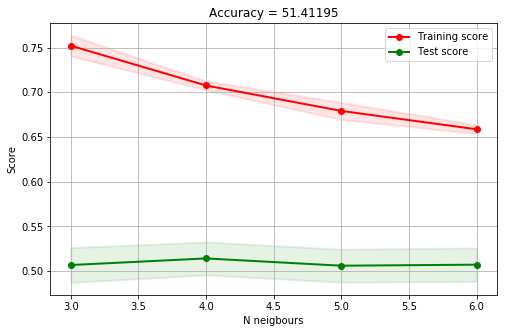

In [261]:
KNeighborsClassifierModel()

c:\users\youssof\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\youssof\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\youssof\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\youssof\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-proce

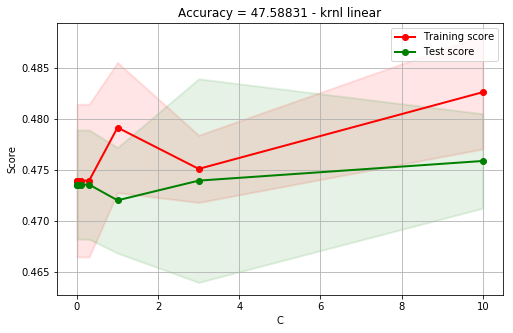

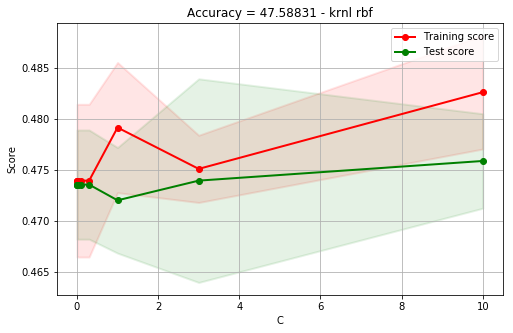

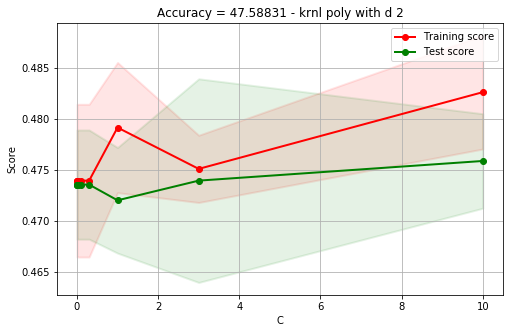

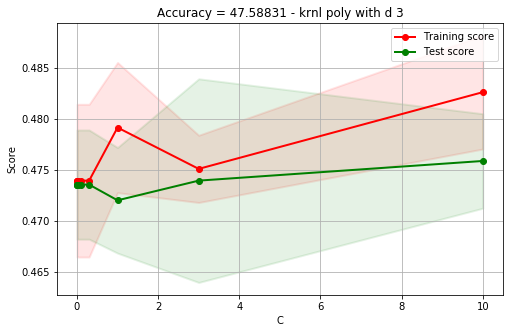

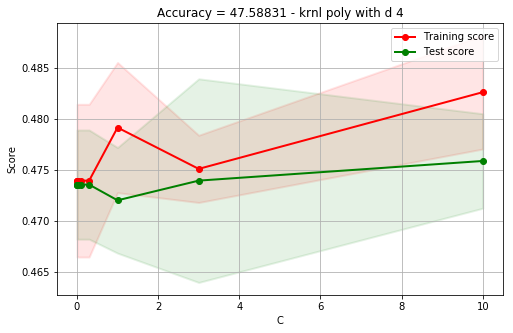

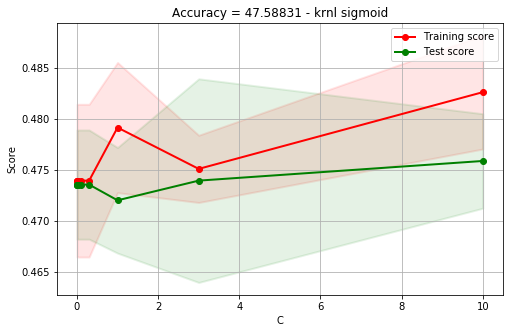

In [270]:
SVCModel()

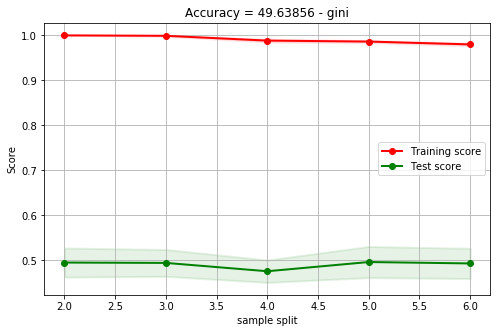

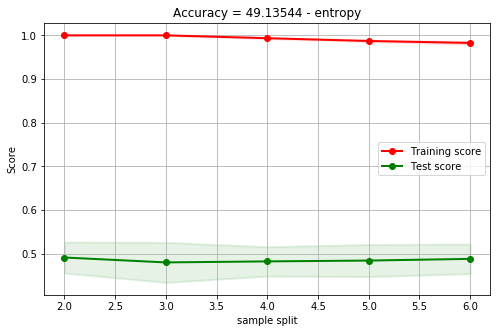

In [263]:
DecisionTreeClassifierModel()

gini 5
gini 10
gini 25
gini 100
gini 130
gini 300
entropy 5
entropy 10
entropy 25
entropy 100
entropy 130
entropy 300


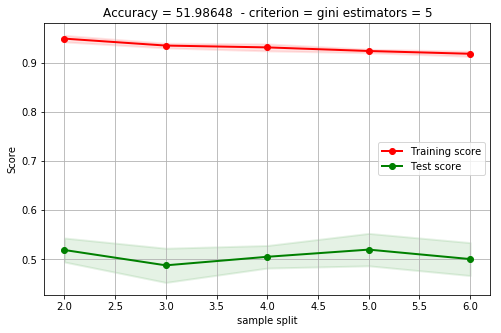

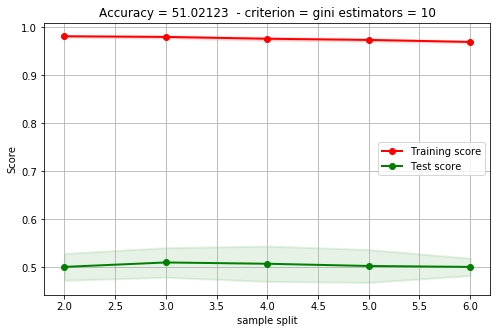

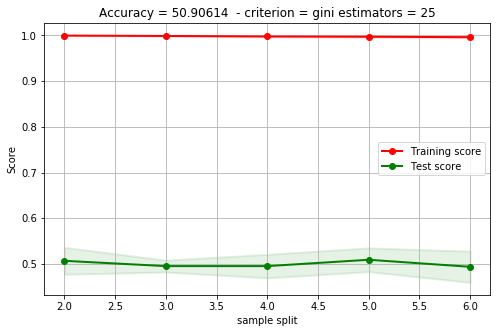

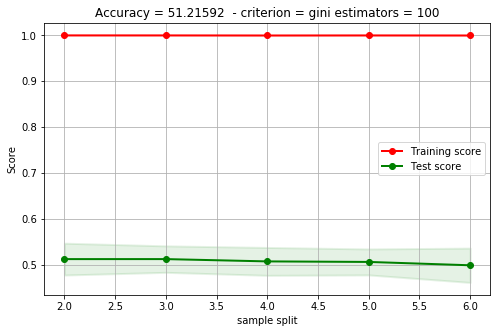

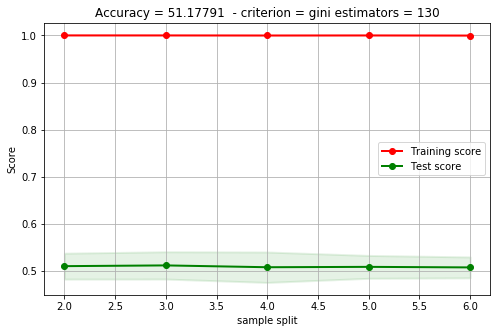

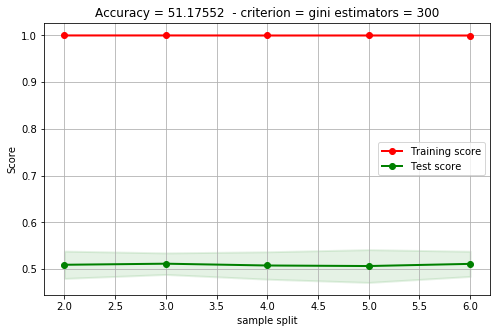

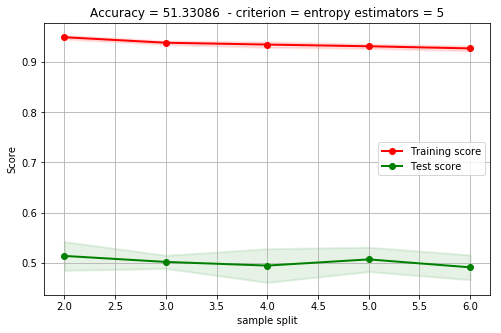

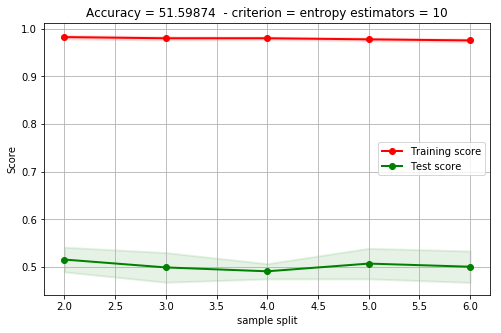

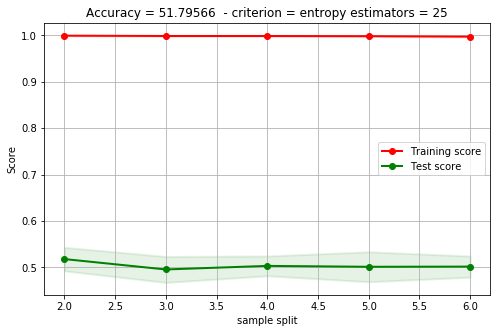

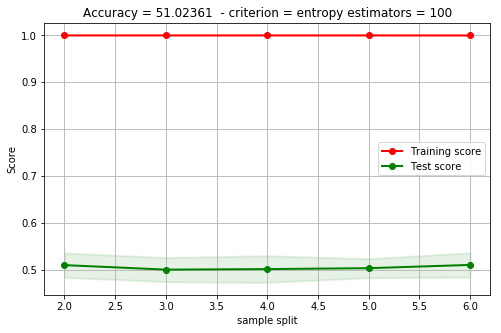

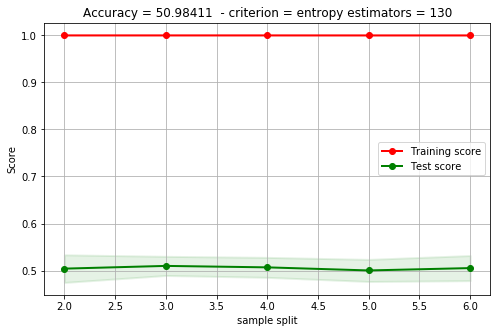

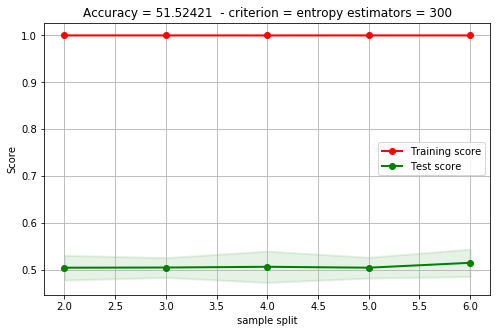

In [266]:
RandomForestClassifierModel()

12


ValueError: shape mismatch: objects cannot be broadcast to a single shape

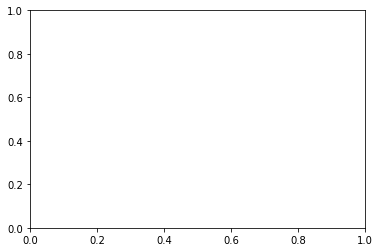

In [209]:
Index = [1,2,3,4,5]
Model = ['LogisticRegressionModel', 'KNeighborsClassifier', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier']
print(len(Accuracy))
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')

In [4]:
# # i = 0
# l = 100 # newslist.size

# for x in range(l):
#     tokens = word_tokenize(newslist[x])
#     all_token.append(tokens)

#     #     i+=1
# for x in range(l):
#     words = [word for word in all_token[x] if word.isalpha()]
#     tokenswithoutpanct.append(words)



# #for x in range(478):
# #    print tokenswithoutpanct[x]

# stop_words = set(stopwords.words('english'))

# for x in range(l):
#     words = [w for w in tokenswithoutpanct[x] if not w in stop_words]
#     tokenswithoutpanctandstopword.append(words)

# porter = PorterStemmer()
# for x in range(l):
#     stemmed = [porter.stem(word) for word in tokenswithoutpanctandstopword[x]]
#     dataafterclean.append(stemmed)
    
# for x in range(10):
#     for y in range(len(dataafterclean[x])):
#         print(str(x) + ' ' + str(y) + ' ' + tokenswithoutpanctandstopword[x][y]+'\t'+dataafterclean[x][y])
        

# # Classifiers = [
# #     LogisticRegression(C=0.0000001,solver='liblinear',max_iter=200),
# #     KNeighborsClassifier(3),
# #     SVC(kernel="rbf", C=0.025, probability=True),
# #     DecisionTreeClassifier(),
# #     RandomForestClassifier(n_estimators=200),
# #     AdaBoostClassifier(),
# #     GaussianNB()]

# # dense_features= np.squeeze(np.asarray(train_features))
# # dense_test= np.squeeze(np.asarray(test_features))
# # Accuracy=[]
# # Model=[]

# # for classifier in Classifiers:
# #     print('Accuracy of '+classifier.__class__.__name__)
# #     try:
# #         fit = classifier.fit(train_features,train['sentiment'])
# #         pred = fit.predict(test_features)
# #     except Exception:
# #         fit = classifier.fit(dense_features,train['sentiment'])
# #         pred = fit.predict(dense_test)
# #     accuracy = accuracy_score(pred,test['sentiment'])
# #     Accuracy.append(accuracy)
# #     print('is ' + str(accuracy))    